In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True

# Path to sledgehamr top directory
sys.path.append('../../sledgehamr')
import pySledgehamr as sledgehamr

exec_dir = "../examples/MinimalExample/"

# Step 1: Create Initial State
### The initial state will be about 513 MB large.

In [4]:
strings = sledgehamr.AxionStrings()
strings.CreateInitialState(L=15, N=256, k_max=2, t_start=0.1, output_file=exec_dir+'initial_state_256.hdf5')

Generate Psi1 ...
Generate Psi2 ...
Generate Pi1 ...
Generate Pi2 ...
Done.


# Step 2: Run the simulation. 
Follow instructions in 'examples/MinimalExample/README'. For reference, the simulation takes just under 5 minutes on a single dual-socket AMD EPYC 7763 node and requires about 825 MB of disk space. Your milage may vary.

# Step 3: Plot Output

### First, create output object. This will identify what kind of output has been written.

In [3]:
output = sledgehamr.Output(exec_dir + 'output')
print()

times_slices = output.GetTimesOfSlices()
print(len(times_slices),'slices written at t =', times_slices)

times_boxes = output.GetTimesOfCoarseBoxes()
print(len(times_boxes),'coarse boxes written at t =', times_boxes)

Number of slices found: 12
Number of coarse boxes found: 3
Number of full boxes found: 0
Number of projections found: 0
Number of spectra found: 0
Number of gravitational wave spectra found: 0
Number of slices of truncation errors found: 0
Number of coarse boxes of truncation errors found: 0
Number of full boxes of truncation errors found: 0

12 slices written at t = [0.1        0.60976562 1.11953125 1.62929688 2.1390625  2.64882813
 3.15859375 3.66835938 4.178125   4.68789062 5.19765625 5.5140625 ]
3 coarse boxes written at t = [0.1        3.10585938 5.5140625 ]


### Now we can load and plot a slice through the field. Here, we plot both the coarse level and the first refinement level.

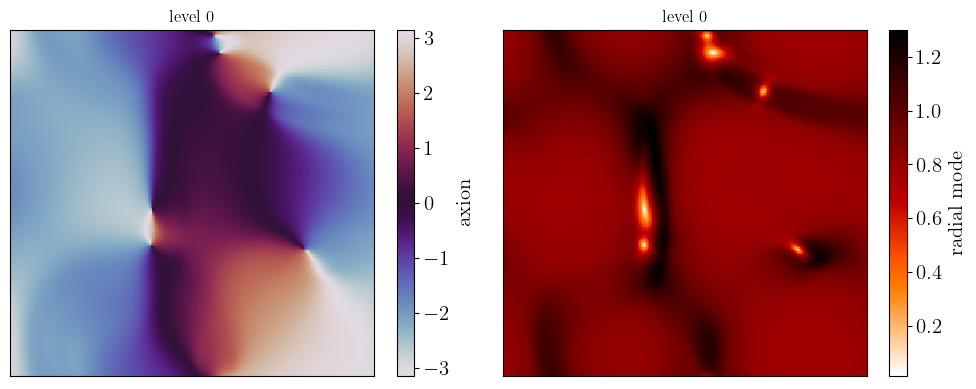

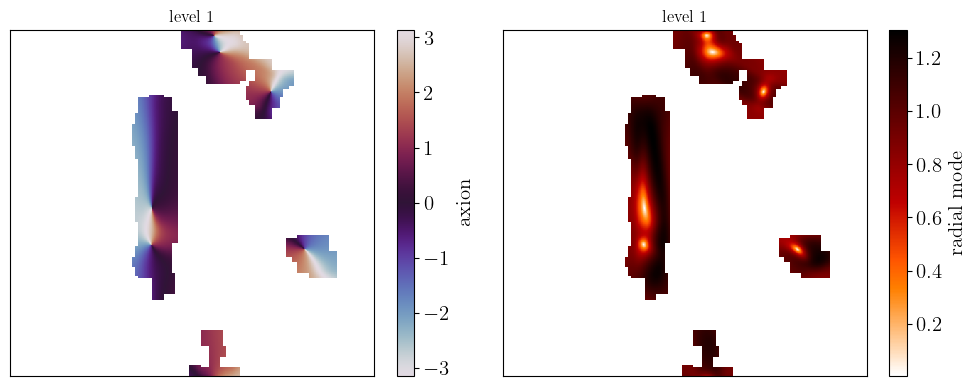

In [8]:
# id of slice to be plotted
i = len(times_slices)-1

for lev in [0,1]:
    # Load data of slice
    slices = output.GetSlice(i, 'x', lev, ['Psi1', 'Psi2'])
    axion = np.arctan2(slices['Psi2'], slices['Psi1'])
    radial_mode = np.sqrt(slices['Psi1']**2 + slices['Psi2']**2)

    fig, ax = plt.subplots(figsize=(10,4), ncols=2)

    axis = np.linspace(0,1,np.shape(axion)[0])
    im = ax[0].pcolormesh(axis, axis, axion, cmap='twilight')
    cb = fig.colorbar(im, ax=ax[0])
    cb.ax.tick_params(labelsize=15)
    cb.set_label(label=r'axion',fontsize=15)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    im = ax[1].pcolormesh(axis, axis, radial_mode, cmap='gist_heat_r')
    cb = fig.colorbar(im, ax=ax[1])
    cb.ax.tick_params(labelsize=15)
    cb.set_label(label=r'radial mode',fontsize=15)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[0].set_title('level '+str(lev))
    ax[1].set_title('level '+str(lev))
    plt.tight_layout()
    plt.savefig('../assets/minimal_example_slice_level_'+str(lev)+'.png')

### Next, we can load the entire coarse level at the end of the simulation and make a 3D surface plot.

In [6]:
i = len(times_boxes)-1

# Load coarse box
coarse_box = output.GetCoarseBox(i, ['Psi1', 'Psi2'])
t = coarse_box['t']
print('t='+str(t))

radial_mode_sq = coarse_box['Psi1']**2 + coarse_box['Psi2']**2

t=5.5140625


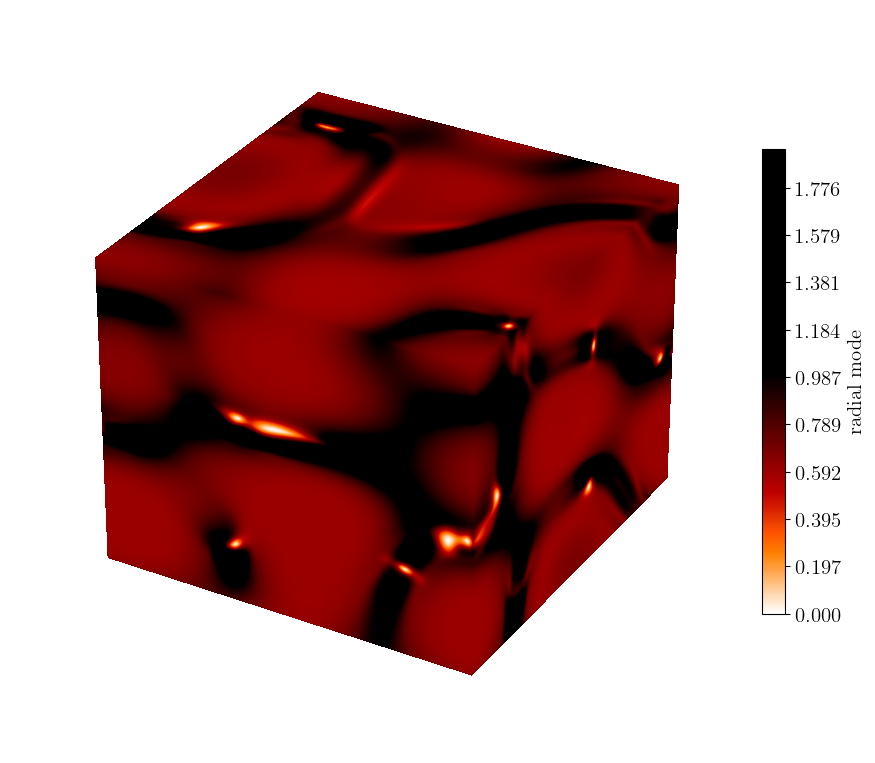

In [7]:
# Define dimensions
Nx, Ny, Nz = 256, 256, 256
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

data = radial_mode_sq

kw = {
    'vmin': data.min(),
    'vmax': 1,#data.max(),
    'levels': np.linspace(data.min(), data.max(), 512),
    'cmap': 'gist_heat_r'
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)

ax.set_axis_off()

cb = fig.colorbar(C, ax=ax, fraction=0.03, pad=0.01)
cb.ax.tick_params(labelsize=15)
cb.set_label(label=r'radial mode',fontsize=15)
plt.tight_layout()
plt.savefig('../assets/minimal_example_box.png')